In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt',quiet = True)
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.callbacks import Callback
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, GlobalAveragePooling1D
from keras.optimizers import Adam
import os

In [3]:
PATH = '/content/gdrive/MyDrive/6120_group/final_proj/'

### IMDB Dataset

In [4]:
movie_review_df = pd.read_csv(PATH + '/preproc_data/balanced_movie_review.csv')

In [5]:
movie_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300924 entries, 0 to 300923
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      300924 non-null  int64 
 1   review_date     300924 non-null  object
 2   movie_id        300924 non-null  object
 3   user_id         300924 non-null  object
 4   is_spoiler      300924 non-null  bool  
 5   review_text     300924 non-null  object
 6   rating          300924 non-null  int64 
 7   review_summary  300923 non-null  object
dtypes: bool(1), int64(2), object(5)
memory usage: 16.4+ MB


In [6]:
# IMDB Preprocessing

movie_review_data = []

# lowercase
movie_review_df['review_text'] = movie_review_df['review_text'].str.lower()

samples = movie_review_df['review_text'].to_numpy()
labels = np.array(movie_review_df['is_spoiler'].values, dtype=np.int64)

print(samples.shape)
print(labels.shape)

(300924,)
(300924,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.2, random_state=10)

In [8]:
# using BOW
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

max_seq_len = 1000
vocab_size = len(tokenizer.word_index)

# encode review texts and add padding
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_seq_len, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_seq_len, padding='post')

In [ ]:
# using word embeddings

In [27]:
print(X_train.shape)
print(X_test.shape)

(240739, 1000)
(60185, 1000)


In [9]:
# hyperparameters

batch_size = 1024
learning_rate = 0.002
embedding_dim = 300

In [12]:
# CNN model

def initialize_model(filters, kernel_size, pooling):
    optimizer = Adam(learning_rate=learning_rate)

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    if pooling == 'max':
        model.add(GlobalMaxPooling1D())
    elif pooling == 'avg':
        model.add(GlobalAveragePooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.build((batch_size, max_seq_len))

    return model

In [ ]:
# k-fold cross validation for hyperparameter tuning
# (filters, kernel_size, max/avg_pool)
hp = [(64, 6, 'max'),  (64, 6, 'max'), (32, 3, 'max'), (32, 6, 'max')]
kfold = KFold(n_splits=4, random_state=10, shuffle=True)

for filters, kernel_size, pool in hp:

    accuracies = []
    for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
        model = initialize_model(filters, kernel_size, pool)

        cv_X_train, cv_y_train = X_train[train_index], y_train[train_index]
        cv_X_val, cv_y_val = X_train[test_index], y_train[test_index]

        model.fit(x=cv_X_train, y=cv_y_train, epochs=1, verbose=1)
        # [loss, accuracy]
        accuracies.append(model.evaluate(x=cv_X_val, y=cv_y_val, verbose=0)[1])

    print(f'filters={filters}, kernel size={kernel_size}, pooling={pool}: accuracy = {np.mean(accuracies)}')
    break



# results:
# filters=32, kernel size=3, pooling=max: accuracy = 0.7475398540496826
# filters=32, kernel size=6, pooling=max: accuracy = 0.7492512762546539
# filters=64, kernel size=3, pooling=max: accuracy = 0.7516771256923676
# filters=64, kernel size=6, pooling=max: accuracy = 0.7508878856897354

5643/5643 [==============================] - 305s 54ms/step - loss: 0.5426 - accuracy: 0.7214
filters=64, kernel size=6, pooling=max: accuracy = 0.7508878856897354


In [14]:
# callback for getting logs at each batch step
class BatchLogger(Callback):
    batch_accuracy = []
    batch_loss = []

    def __init__(self):
        super().__init__()
        
    def on_train_batch_end(self, batch, logs=None):                
        BatchLogger.batch_accuracy.append(logs.get('accuracy'))
        BatchLogger.batch_loss.append(logs.get('loss'))

In [20]:
# CNN model

model = initialize_model(filters=64, kernel_size=3, pooling='max')

In [22]:
# training
# if os.path.exists(PATH + 'imdb_cnn_model'):
#     model = load_model(PATH + 'imdb_cnn_model')

model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=2, callbacks=[BatchLogger()])
model.save(PATH + 'imdb_cnn_model')

Epoch 1/2
   5/7524 [..............................] - ETA: 6:34 - loss: 0.6920 - accuracy: 0.5625

7524/7524 [==============================] - 382s 50ms/step - loss: 0.5325 - accuracy: 0.7294 - val_loss: 0.4997 - val_accuracy: 0.7538
Epoch 2/2
7524/7524 [==============================] - 377s 50ms/step - loss: 0.4499 - accuracy: 0.7863 - val_loss: 0.4947 - val_accuracy: 0.7583


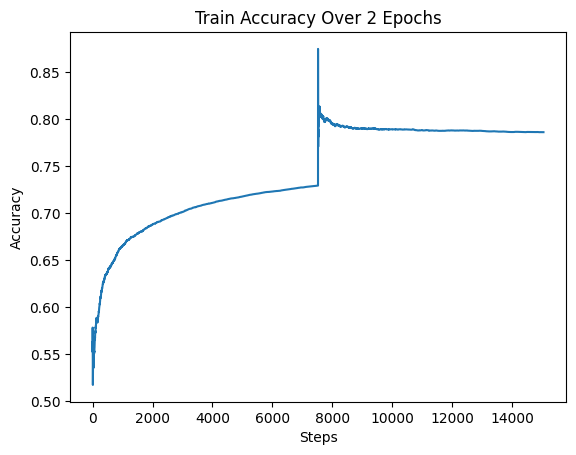

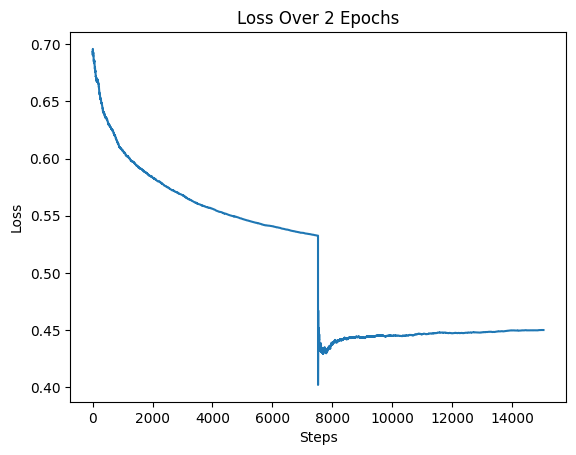

In [23]:
# graph loss and accuracy

plt.title('Train Accuracy Over 2 Epochs')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.plot(BatchLogger.batch_accuracy)
plt.show()

plt.title('Loss Over 2 Epochs')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(BatchLogger.batch_loss)
plt.show()

1881/1881 [==============================] - 7s 4ms/step
              precision    recall  f1-score   support

           0       0.71      0.88      0.78     29985
           1       0.84      0.64      0.73     30200

    accuracy                           0.76     60185
   macro avg       0.78      0.76      0.75     60185
weighted avg       0.78      0.76      0.75     60185



Text(0.5, 1.0, 'Confusion Matrix for Test set')

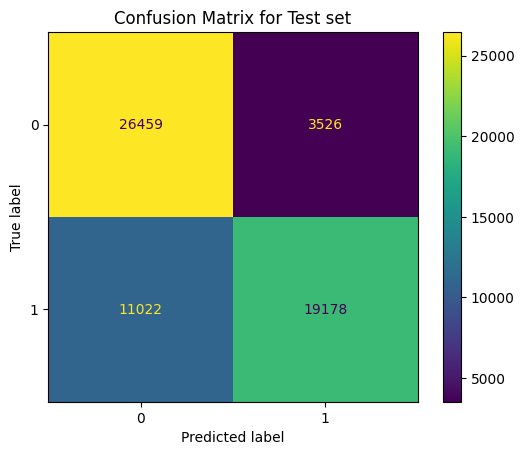

In [24]:
# Confusion Matrix

label_pred = model.predict(X_test)

for i in range(len(label_pred)):
    label_pred[i] = 0 if label_pred[i] < 0.5 else 1

print(classification_report(y_test, label_pred))

ConfusionMatrixDisplay.from_predictions(y_test, label_pred)
plt.title("Confusion Matrix for Test set")

### Bookreads Dataset

In [4]:
# Bookreads dataset

book_review_df = pd.read_json(PATH + 'goodreads_reviews_spoiler.json', lines=True, nrows=100000)

In [5]:
book_review_df.head()

,user_id,timestamp,review_sentences,rating,has_spoiler,book_id,review_id
0,8842281e1d1347389f2ab93d60773d4d,2017-08-30,"[[0, This is a special book.], [0, It started ...",5,True,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb
1,8842281e1d1347389f2ab93d60773d4d,2017-03-22,"[[0, Recommended by Don Katz.], [0, Avail for ...",3,False,16981,a5d2c3628987712d0e05c4f90798eb67
2,8842281e1d1347389f2ab93d60773d4d,2017-03-20,"[[0, A fun, fast paced science fiction thrille...",3,True,28684704,2ede853b14dc4583f96cf5d120af636f
3,8842281e1d1347389f2ab93d60773d4d,2016-11-09,"[[0, Recommended reading to understand what is...",0,False,27161156,ced5675e55cd9d38a524743f5c40996e
4,8842281e1d1347389f2ab93d60773d4d,2016-04-25,"[[0, I really enjoyed this book, and there is ...",4,True,25884323,332732725863131279a8e345b63ac33e


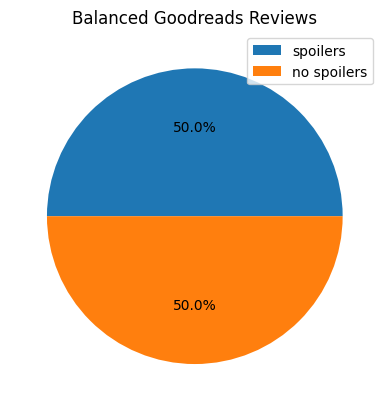

<ipython-input-6-fd3b39f0015f>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  book_review_df = spoilers.append(no_spoilers, ignore_index=True)


In [6]:
spoilers = book_review_df[book_review_df['has_spoiler'] == True]
no_spoilers = book_review_df[book_review_df['has_spoiler'] == False]

# balance dataset (remove neg labels)

# get indices of reviews with no spoilers
no_spoilers_indices = book_review_df.index[book_review_df['has_spoiler'] == True]
removed_indices = no_spoilers_indices[:150000]
no_spoilers = book_review_df.iloc[removed_indices]

# plot dataset with neg labels removed
plt.pie([len(spoilers), len(no_spoilers)], autopct='%1.1f%%')
plt.title('Balanced Goodreads Reviews')
plt.legend(['spoilers', 'no spoilers'])
plt.show()

book_review_df = spoilers.append(no_spoilers, ignore_index=True)

In [ ]:
book_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12836 entries, 0 to 12835
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           12836 non-null  object        
 1   timestamp         12836 non-null  datetime64[ns]
 2   review_sentences  12836 non-null  object        
 3   rating            12836 non-null  int64         
 4   has_spoiler       12836 non-null  bool          
 5   book_id           12836 non-null  int64         
 6   review_id         12836 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(2), object(3)
memory usage: 614.3+ KB


In [7]:
# Bookreads Preprocessing

samples = []
labels = []

for review in tqdm(book_review_df['review_sentences'].values):
    for entry in review:
        # get samples and labels
        sent = entry[1]
        label = entry[0]
        samples.append(sent)
        labels.append(label)


samples = np.array(samples)
labels = np.array(labels)

print(samples.shape)
print(labels.shape)

100%|██████████| 12836/12836 [00:00<00:00, 33073.57it/s]


(289902,)
(289902,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.2, random_state=5)

In [9]:
# using BOW
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

max_seq_len = 50
vocab_size = len(tokenizer.word_index)

# encode review texts and add padding
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_seq_len, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_seq_len, padding='post')

In [ ]:
# using word embeddings

In [ ]:
print(X_train.shape)
print(X_test.shape)

(231921, 50)
(57981, 50)


In [10]:
# hyperparameters

batch_size = 1024
learning_rate = 0.002
embedding_dim = 300

In [ ]:
# k-fold cross validation for hyperparameter tuning
# (filters, kernel_size, max/avg_pool)
hp = [(64, 3, 'max'),  (64, 6, 'max'), (32, 3, 'max'), (32, 6, 'max')]
kfold = KFold(n_splits=5, random_state=10, shuffle=True)

for filters, kernel_size, pool in hp:

    accuracies = []
    for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
        model = initialize_model(filters, kernel_size, pool)

        cv_X_train, cv_y_train = X_train[train_index], y_train[train_index]
        cv_X_val, cv_y_val = X_train[test_index], y_train[test_index]

        model.fit(x=cv_X_train, y=cv_y_train, epochs=1, verbose=1)
        # [loss, accuracy]
        accuracies.append(model.evaluate(x=cv_X_val, y=cv_y_val, verbose=0)[1])

    print(f'filters={filters}, kernel size={kernel_size}, pooling={pool}: accuracy = {np.mean(accuracies)}')

# results
# filters=32, kernel size=3, pooling=max: accuracy = 0.7795
# filters=64, kernel size=3, pooling=max: accuracy =   0.77996
# filters=32, kernel size=6, pooling=max: accuracy = 0.7812
# filters=64, kernel size=6, pooling=max: accuracy = 0.7874

5799/5799 [==============================] - 66s 11ms/step - loss: 0.5004 - accuracy: 0.7611
filters=64, kernel size=3, pooling=max: accuracy = 0.7799638509750366
5799/5799 [==============================] - 67s 11ms/step - loss: 0.4991 - accuracy: 0.7613
filters=64, kernel size=6, pooling=max: accuracy = 0.7807399868965149


In [19]:
# CNN model

model = initialize_model(filters=64, kernel_size=6, pooling='max')

In [21]:
# training
# if os.path.exists(PATH + 'bookreads_cnn_model'):
#     model = load_model(PATH + 'bookreads_cnn_model')

model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=2, callbacks=[BatchLogger()])
model.save(PATH + 'bookreads_cnn_model')


Epoch 1/2
7248/7248 [==============================] - 89s 12ms/step - loss: 0.4715 - accuracy: 0.7793 - val_loss: 0.4357 - val_accuracy: 0.8013
Epoch 2/2
7248/7248 [==============================] - 89s 12ms/step - loss: 0.3419 - accuracy: 0.8520 - val_loss: 0.3734 - val_accuracy: 0.8431


In [ ]:
# graph loss and accuracy

plt.title('Train Accuracy Over 2 Epochs')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.plot(BatchLogger.batch_accuracy)
plt.show()

plt.title('Loss Over 2 Epochs')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(BatchLogger.batch_loss)
plt.show()

1812/1812 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     42655
           1       0.80      0.55      0.65     15326

    accuracy                           0.84     57981
   macro avg       0.82      0.75      0.77     57981
weighted avg       0.84      0.84      0.83     57981



Text(0.5, 1.0, 'Confusion Matrix for Test set')

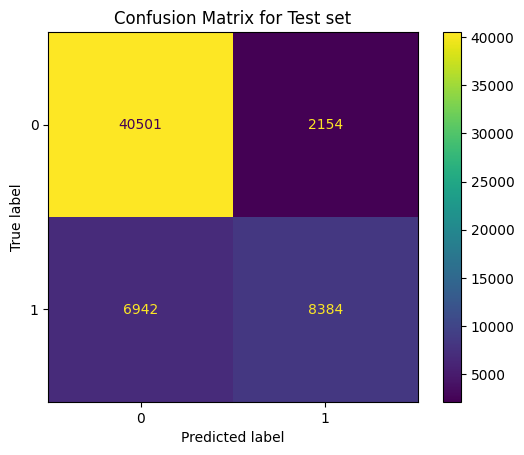

In [23]:
# Confusion Matrix

label_pred = model.predict(X_test)

for i in range(len(label_pred)):
    label_pred[i] = 0 if label_pred[i] < 0.5 else 1

print(classification_report(y_test, label_pred))

ConfusionMatrixDisplay.from_predictions(y_test, label_pred)
plt.title("Confusion Matrix for Test set")